**유전 알고리즘 고교 학점제 동선 효율화**


유전 알고리즘
(https://blex.me/@baealex/%ED%8C%8C%EC%9D%B4%EC%8D%ACpython-%EC%9C%A0%EC%A0%84-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EA%B8%B0%EB%B3%B8)

##### 전민국 선배(rzbsys) 유전 알고리즘 자료 참고_유전 알고리즘 수행 과정 변경 및 성능 개선 및 실험
>> http://colorscripter.com/s/kxFWrtz -
코드 내 방법론 : 플로이드 워셜/룰렛휠/싸이클 교차를 사용
>>> 도출 결과(고정된 값은 아니지만) :
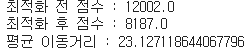

**유전 알고리즘 수행 과정을 변경해보자!**

**< 1 > OrderCrossOver 및 룰렛휠에 Elitism(엘리티즘)을 적용하여 수행**

한 교실에서 선생님은 고정, 학생들은 시간표에 따라 교실 이동

In [ ]:
NUM_OF_CHROMOSOME = 20
SWAP_THRESHOLD = 0.4

**초기유전자 생성**

In [ ]:
class Chromosome():
    def __init__(self, gene, fitness):
        # gene은 1차원 배열(학교 수업) -> 학교 시간표로 수업 생성
        self.Gene = gene
        self.Fitness = fitness

제작해놓으신 학교 홈페이지 인접행렬 데이터 이용

In [ ]:
# 전민국 선배가 학교 홈페이지 바탕으로 구성한 행렬 데이터
# 교실간의 연결 관계를 나타내는 데이터
!wget -O graph.txt https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
# 학생들의 시간표 정보가 담긴 데이터
!wget -O timetable.csv https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv


--2023-10-27 09:56:29--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘graph.txt’

graph.txt           100%[===================>]     595  --.-KB/s    in 0s      

2023-10-27 09:56:29 (45.7 MB/s) - ‘graph.txt’ saved [595/595]

--2023-10-27 09:56:29--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177166 (173K) [text/plain]
Saving to: ‘timetable.csv’

기본 설정 값 지정
- 플로이드 워셜을 사용해야 해서 INF 값으로 초기 TImestep의 무한 표현 변수를 지정
- MAX_NODE는 불러온 데이터의 최대 크기
- MAX_CNT는 시간표 데이터를 가져오고 요일별 분류할 때 사용

In [ ]:
MAX_NODE = 79
INF = 2000000
MAX_CNT = [7, 7, 4, 7, 7]

In [ ]:
import numpy as np

def LoadInitGraph(max_cnt, source):
    graph = np.ones((max_cnt + 1, max_cnt + 1))
    # 모든 배열을 -1로 초기화
    # -1은 갈수 없음을 의미한다.
    graph = graph * -1

    with open(source, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break

            start, to = line.split(' ')
            start = int(start)
            to = int(to)
            # cost를 교실간의 거리로 업데이트하면 정확도가 높아질수 있음.
            cost = 1

            # 양방향 그래프
            graph[start][to] = cost
            graph[to][start] = cost

    # 자기 자신으로 가는 최소비용은 0이다.
    for i in range(max_cnt + 1):
        graph[i][i] = 0

    return graph

SchoolGraph = LoadInitGraph(MAX_NODE, '/content/graph.txt')

# 이동 가능
print('62와 62 교실을 이동하는데 드는 비용 :', SchoolGraph[62][63])
# 이동 불가능
print('62와 64 교실을 이동하는데 드는 비용 :', SchoolGraph[62][64])

62와 62 교실을 이동하는데 드는 비용 : 1.0
62와 64 교실을 이동하는데 드는 비용 : -1.0


그래프 불러옴(비용 지정)

In [ ]:
import numpy as np

def LoadInitGraph(max_cnt, source):
    graph = np.ones((max_cnt + 1, max_cnt + 1))
    # 모든 배열을 -1로 초기화
    # -1은 갈수 없음을 의미한다.
    graph = graph * -1

    with open(source, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break

            start, to = line.split(' ')
            start = int(start)
            to = int(to)
            # cost를 교실간의 거리로 업데이트하면 정확도가 높아질수 있음.
            # 추후 누군가 해주지 않을까...
            cost = 1

            # 양방향 그래프
            graph[start][to] = cost
            graph[to][start] = cost

    # 자기 자신으로 가는 최소비용은 0이다.
    for i in range(max_cnt + 1):
        graph[i][i] = 0

    return graph

SchoolGraph = LoadInitGraph(MAX_NODE, '/content/graph.txt')

# 이동 가능
print('62와 62 교실을 이동하는데 드는 비용 :', SchoolGraph[62][63])
# 이동 불가능
print('62와 64 교실을 이동하는데 드는 비용 :', SchoolGraph[62][64])

62와 62 교실을 이동하는데 드는 비용 : 1.0
62와 64 교실을 이동하는데 드는 비용 : -1.0


**벨만 포드 알고리즘 사용** (https://8iggy.tistory.com/153)

일단 기본으로 사용되었던 벨만포드 알고리즘을 사용하여 적합도 계산을 할거라 함수 지정

In [ ]:
def FloydWarshall(graph, max_cnt):
    # 배열 초기화
    dist = np.where(graph == -1, INF, graph)

    # 3중 반복문 - 플로이드 워셜
    for i in range(max_cnt + 1):
        for t in range(max_cnt + 1):
            for j in range(max_cnt + 1):
                if dist[t][i] + dist[i][j] < dist[t][j]:
                    dist[t][j] = dist[t][i] + dist[i][j]

    return dist

DistGraph = FloydWarshall(SchoolGraph, MAX_NODE)
print('요양원에서 집까지 이동하는데 걸리는 최단경로 :', DistGraph[43][18])
print('요양원에서 집까지 이동하는데 걸리는 최단경로 :', DistGraph[18][43])

요양원에서 집까지 이동하는데 걸리는 최단경로 : 9.0
요양원에서 집까지 이동하는데 걸리는 최단경로 : 9.0


시간표 요일별 분배

In [ ]:
import pandas as pd

def LoadTimetable(source):
    df = pd.read_csv(source, header=None)
    period_list = []
    for index, item in enumerate(MAX_CNT):
        start_index = sum(MAX_CNT[:index])
        temp = df[range(start_index, start_index + item)]
        period_list.append(temp)
    return period_list

Timetable  = LoadTimetable('/content/timetable.csv')
print('시간표 5개')
Timetable[0].head()

시간표 5개


,0,1,2,3,4,5,6
0,생활과 과학/225,한국지리/421,일본어Ⅰ/423,문학/321,수학Ⅰ/420,생활과 윤리/324,영어Ⅰ/422
1,사회문제 탐구/421,영어 회화/222,영어Ⅰ/314,문학/321,생활과 윤리/324,운동과 건강/-1,수학Ⅰ/413
2,영어Ⅰ/222,생활과 윤리/324,화법과 작문/321,수학Ⅰ/413,중국어Ⅰ/404,화학Ⅰ/423,문학/321
3,사회문제 탐구/421,수학Ⅰ/420,화법과 작문/321,문학/321,정치와 법/422,영어Ⅰ/314,운동과 건강/-1
4,수학Ⅰ/0,화학Ⅰ/423,문학/323,실용 수학/322,영어Ⅰ/314,지구과학Ⅰ/216,일본어Ⅰ/423


시간표로 수업이 담겨있는 딕셔너리를 만들어줌.

In [ ]:
def ExtractSubject(timetable):
    subject = set()
    def extract(inp):
        if '-1' in inp:
            return
        subject.add(inp)

    for i in timetable:
        i.applymap(extract)

    res = dict()
    for index, item in enumerate(subject):
        res[item] = index
    return res

Subject = ExtractSubject(Timetable)

print('전체 수업 개수 :', len(Subject))
print('수업 목록 :', Subject)

전체 수업 개수 : 41
수업 목록 : {'창체/423': 0, '창체/420': 1, '생활과 윤리/324': 2, '인문학/415': 3, '화학Ⅰ/214': 4, '창의경영/312': 5, '한국지리/421': 6, '창체/324': 7, '영어 회화/222': 8, '생활과 과학/225': 9, '수학Ⅰ/0': 10, '사회문제 탐구/421': 11, '물리학Ⅰ/211': 12, '실용 수학/322': 13, '지구과학Ⅰ/216': 14, '창체/321': 15, '문학/223': 16, '문학/323': 17, '영미 문학 읽기/422': 18, '영어Ⅰ/222': 19, '문학/321': 20, '영어Ⅰ/422': 21, '공학 일반/407': 22, '영어Ⅰ/314': 23, '중국어Ⅰ/404': 24, '인문학/302': 25, '정치와 법/422': 26, '사회문제 탐구/127': 27, '수학Ⅰ/420': 28, '창체/421': 29, '수학Ⅰ/413': 30, '생명과학Ⅰ/216': 31, '화법과 작문/321': 32, '미술/114': 33, '창체/223': 34, '창체/322': 35, '물리학Ⅰ/414': 36, '창체/314': 37, '화학Ⅰ/423': 38, '창체/413': 39, '일본어Ⅰ/423': 40}


딕셔너리를 참고해서 시간표를 숫자로 변경

In [ ]:
# 과목명을 위에서 정의한 과목 숫자로 변경
def ConvertStringToNumber(inp):
    try:
        return Subject[inp]
    except:
        return -1

IndexedTimetable = []
for i in range(len(Timetable)):
    IndexedTimetable.append(Timetable[i].applymap(ConvertStringToNumber))

print("번호가 부여된 월요일 시간표")
IndexedTimetable[0].head()

번호가 부여된 월요일 시간표


,0,1,2,3,4,5,6
0,9,6,40,20,28,2,21
1,11,8,23,20,2,-1,30
2,19,2,32,30,24,38,20
3,11,28,32,20,26,23,-1
4,10,38,17,13,23,14,40


적합도 계산 함수

In [ ]:
def GetFitness(gene):
    fitness = 0
    for timetable in IndexedTimetable:
        for subject_list in timetable.iterrows():
            for index in range(len(subject_list[1]) - 1):
                before_sub = subject_list[1][index]
                after_sub = subject_list[1][index + 1]

                if before_sub == -1 or after_sub == -1:
                    continue

                before_cls = gene[before_sub]
                after_cls = gene[after_sub]

                dist = DistGraph[before_cls][after_cls]

                fitness = (fitness + dist)
        return fitness

초기 염색체 생성 과정

In [ ]:
def GenerateGenesis(max_len, num):
    population = []
    for _ in range(num):
        gene = np.random.choice(range(1, max_len + 1), max_len, replace=False)
        fitness = GetFitness(gene)
        population += [Chromosome(gene, fitness)]
    return population

**엘리티즘 + 룰렛휠의 방식으로 동작시킬 것임.**

염색체의 선택 과정


**엘리티즘 방식으로 먼저 선별하고, 룰렛휠을 동작 / 마지막 유전알고리즘 수행과정에서 엘리티즘 기법을 적용**

룰렛휠 : 염색체들의 적합도에 비례해서 개체군에서 다음 세대로 넘겨 줄 염색체를 선택하는 방법

- 적합도 점수가 높을수록 선택될 확률이 높은 방법

가장 적합한 염색체가 다음 세대로 전달되는 것을 보장하는 것이 아니라 그것들이 그렇게 될 가능성을 높여주는 방법
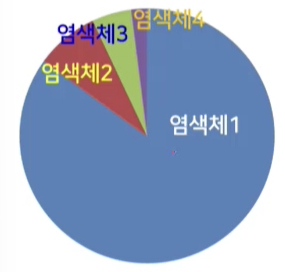

엘리티즘 : 가장 좋은 몇 개의 염색체를 아무런 변화 없이 새로운 개체군으로 그대로 복사한 후, 나머지는 전형적인 방법과 동일하게 동작

- 교차와 변이 과정에서 가장 좋은 염색체의 분실 가능성을 방지
- 급격한 성능 향상이 가능



In [ ]:
def Selection(population_set):
    # 점수가 높을 수록 안좋은 유전자이기에 역수를 취해 바꾸어줌.
    fitness_list = [1 / population_set[i].Fitness for i in range(len(population_set))]
    total_fitness = np.sum(fitness_list)
    prob_list = fitness_list / total_fitness

    # 두 집단을 선택하고 두 집단을 Crossover할 예정
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list, replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list, replace=True)

    progenitor_a = []
    progenitor_b = []
    for i in progenitor_list_a:
        progenitor_a += [population_set[i]]

    for i in progenitor_list_b:
        progenitor_b += [population_set[i]]

    return [progenitor_a, progenitor_b]

**Crossover 연산 과정 - Oreder CrossOver**


행렬의 중복을 피하면서도 합리적인 크로스오버 과정을 진행해야함

Order 교차를 사용 : Order Crossover: 염색체가 순열로 표시되는 경우을 위하여 고안된 교차 연산자이다. 먼저 임의로 두 개의 자름선을 정한 다음 두 자름선 사이에 있는 첫 번째 부모의 염색체 부분을 복사한다.

>> Order Crossover가 Cycle 교차보다 합리적일 가능성이 있을 이유 (어떤 교차가 효율적인지는 예측하기 어려움)
1. 순서 보존: 최단 경로 문제에서 유전자(경로에 있는 노드 또는 도시)의 순서는 최단 경로 자체를 찾는 것보다 덜 중요하다. OX는 부모 사이에서 유전자를 섞음으로써 더 많은 다양성을 도입하여 유전자 알고리즘이 더 넓은 범위의 잠재적 경로를 탐색할 수 있도록 한다.
>>
>>2. 탐색 및 활용: OX는 검색 공간 탐색을 촉진하므로 이는 최적의 경로를 검색할 때 특히 유용할 수 있다. 이러한 탐색은 로컬 최적 상태에서 벗어나 더 나은 솔루션을 찾는 데 필수적이다.
>>
>>3. 주기 위험 감소: CX는 경로 문제의 맥락에서 바람직하지 않은 주기가 있는 자손을 생산할 수 있다. 그치만 OX는 한 부모의 경로 중 일부를 선택한 다음 주기를 생성하지 않고 다른 부모의 유전자로 나머지 부분을 채우기 때문에 주기의 위험을 줄일 수 있는 가능성이 있다.

In [ ]:
def OrderCrossover(chromosome1, chromosome2):
    gene1 = chromosome1.Gene
    gene2 = chromosome2.Gene

    # 두 부모 염색체 중에서 랜덤한 부분을 선택
    start, end = sorted(np.random.choice(len(gene1), 2, replace=False))
    child_gene = [-1] * len(gene1)

    # 선택한 부분을 첫 번째 자식에 복사
    child_gene[start:end] = gene1[start:end]

    # 두 번째 부모의 염색체에서 아직 복사되지 않은 유전자를 추가
    index = end
    for i in range(end, len(gene2) + end):
        if gene2[i % len(gene2)] not in child_gene:
            child_gene[index % len(gene2)] = gene2[i % len(gene2)]
            index += 1

    fitness = GetFitness(child_gene)
    return Chromosome(child_gene, fitness)

**돌연변이 연산**

여기서는 행렬이 중복되지 않아야 하는 프로젝트 그대로 기존 Swap Mutation 그대로 진행

In [ ]:
import random

def SwapMutation(chromosomes):
    gene = chromosomes.Gene

    percentage = random.random()
    if (percentage <= SWAP_THRESHOLD):
        point1, point2 = np.random.choice(range(len(gene)), 2, replace=False)
        gene[point1], gene[point2] = gene[point2], gene[point1]

    fitness = GetFitness(gene)
    return Chromosome(gene, fitness)


**유전 알고리즘 진행**

엘리티즘 방식 함께 적용하여 진행

엘리트로 선택할 염색체 수를 지정해줄 수 있음.

In [ ]:
NUM_OF_ELITES = 2  # 엘리트 선택할 염색체 수

population = GenerateGenesis(len(Subject), NUM_OF_CHROMOSOME)
global_min = INF
min_chromosome = []

for dur in range(10):
    progenitor_list = Selection(population)
    population = []

    # 엘리트 염색체 선택: 상위 NUM_OF_ELITES 개의 염색체는 그대로 다음 세대로 복사
    elites = sorted(progenitor_list[0], key=lambda chromosome: chromosome.Fitness)[:NUM_OF_ELITES]
    population.extend(elites)

    for _ in range(NUM_OF_CHROMOSOME - NUM_OF_ELITES):
        a, b = np.random.choice(range(len(progenitor_list[0])), 2, replace=False)
        child = OrderCrossover(progenitor_list[0][a], progenitor_list[0][b])
        child = SwapMutation(child)
        population.append(child)

    population = sorted(population, key=lambda chromosome: chromosome.Fitness)
    print('%d회 : %d' % (dur + 1, population[0].Fitness))

    if global_min > population[0].Fitness:
        min_chromosome = population[0]
        global_min = population[0].Fitness
        print('update!')


1회 : 9439
update!
2회 : 9062
update!
3회 : 9062
4회 : 9062
5회 : 8812
update!
6회 : 8812
7회 : 8812
8회 : 8812
9회 : 8812
10회 : 8711
update!


결과 도출

In [ ]:
before_ga = {'창체/223': 25, '수학Ⅰ/420': 62, '화학Ⅰ/214': 18, '문학/323': 44, '창체/421': 63, '창체/324': 46, '인문학/302': 40, '창체/413': 53, '창체/321': 42, '생활과 윤리/324': 46, '영어Ⅰ/222': 24, '영미 문학 읽기/422': 64, '화학Ⅰ/423': 66, '한국지리/421': 63, '문학/223': 25, '창체/322': 43, '일본어Ⅰ/423': 66, '수학Ⅰ/413': 53, '인문학/415': 55, '실용 수학/322': 43, '영어Ⅰ/314': 34, '생명과학Ⅰ/216': 19, '물리학Ⅰ/211': 15, '창체/314': 34, '물리학Ⅰ/414': 54, '화법과 작문/321': 42, '정치와 법/422': 64, '영어Ⅰ/422': 64, '미술/114': 3, '창체/420': 62, '사회문제 탐구/421': 63, '지구과학Ⅰ/216': 19, '수학Ⅰ/0': 43, '문학/321': 42, '창의경영/312': 32, '공학 일반/407': 76, '영어 회화/222': 24, '사회문제 탐구/127': 11, '생활과 과학/225': 28, '중국어Ⅰ/404': 75, '창체/423': 66}
gene = []
for i in Subject:
    gene += [before_ga[i]]
fitness = GetFitness(gene)
print('최적화 전 점수 :', fitness)
print('최적화 후 점수 :', min_chromosome.Fitness)

# 354 = 학생수(추정)
print('평균 이동거리 :', min_chromosome.Fitness / 354)

print('최적 교실 배치')
for sub, cls in zip(Subject, min_chromosome.Gene):
    print(sub, cls, sep=' : ')

최적화 전 점수 : 12002.0
최적화 후 점수 : 8711.0
평균 이동거리 : 24.60734463276836
최적 교실 배치
창체/423 : 1
창체/420 : 3
생활과 윤리/324 : 29
인문학/415 : 19
화학Ⅰ/214 : 18
창의경영/312 : 27
한국지리/421 : 15
창체/324 : 11
영어 회화/222 : 22
생활과 과학/225 : 6
수학Ⅰ/0 : 36
사회문제 탐구/421 : 4
물리학Ⅰ/211 : 38
실용 수학/322 : 9
지구과학Ⅰ/216 : 26
창체/321 : 16
문학/223 : 41
문학/323 : 23
영미 문학 읽기/422 : 33
영어Ⅰ/222 : 24
문학/321 : 13
영어Ⅰ/422 : 17
공학 일반/407 : 35
영어Ⅰ/314 : 34
중국어Ⅰ/404 : 37
인문학/302 : 10
정치와 법/422 : 25
사회문제 탐구/127 : 32
수학Ⅰ/420 : 20
창체/421 : 14
수학Ⅰ/413 : 12
생명과학Ⅰ/216 : 7
화법과 작문/321 : 30
미술/114 : 28
창체/223 : 8
창체/322 : 2
물리학Ⅰ/414 : 5
창체/314 : 39
화학Ⅰ/423 : 40
창체/413 : 31
일본어Ⅰ/423 : 21


###### **여러번 돌려본 결과, 평균 거리를 1~3 정도 효율화 시킨 것 같음**

기존진행

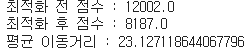

< 1 >의 결과


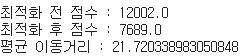

**< 2 >  벨만포드를 이용한 유전 알고리즘 수행 변경**

이번에는 벨만포드를 이용하여 적합도 구성을 변경해보겠음.



=> 정점 간 최단경로를 모두 구하는 것이라 간선이 엄청 많지는 않은 지금 문제상황에서는 플로이드가 유리할 가능성이 높지만 비교해보겠음.

In [ ]:
import numpy as np
import pandas as pd
import random

NUM_OF_CHROMOSOME = 20
SWAP_THRESHOLD = 0.4

MAX_NODE = 79
INF = 2000000
MAX_CNT = [7, 7, 4, 7, 7]

class Chromosome():
    def __init__(self, gene, fitness):
        # gene은 1차원 배열(학교 수업)
        self.Gene = gene
        self.Fitness = fitness

# 교실간의 연결 관계를 나타내는 데이터
!wget -O graph.txt https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
# 학생들의 시간표 정보가 담긴 데이터
!wget -O timetable.csv https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv

def LoadInitGraph(max_cnt, source):
    graph = np.ones((max_cnt + 1, max_cnt + 1))
    # 모든 배열을 -1로 초기화
    # -1은 갈수 없음을 의미한다.
    graph = graph * -1

    with open(source, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break

            start, to = line.split(' ')
            start = int(start)
            to = int(to)
            # cost를 교실간의 거리로 업데이트하면 정확도가 높아질수 있음.
            # 추후 누군가 해주지 않을까...
            cost = 1

            # 양방향 그래프
            graph[start][to] = cost
            graph[to][start] = cost

    # 자기 자신으로 가는 최소비용은 0이다.
    for i in range(max_cnt + 1):
        graph[i][i] = 0

    return graph

SchoolGraph = LoadInitGraph(MAX_NODE, 'graph.txt')

def BellmanFord(graph, start):
    dist = [INF] * len(graph)
    dist[start] = 0

    for _ in range(len(graph)):
        for u in range(len(graph)):
            for v in range(len(graph)):
                if graph[u][v] != -1 and dist[u] + graph[u][v] < dist[v]:
                    dist[v] = dist[u] + graph[u][v]

    return dist

def CalculateAllPairsShortestPath(graph):
    shortest_paths = []
    for start in range(len(graph)):
        shortest_paths.append(BellmanFord(graph, start))
    return shortest_paths

DistGraph = CalculateAllPairsShortestPath(SchoolGraph)

print('요양원에서 집까지 이동하는데 걸리는 최단경로 :', DistGraph[43][18])
print('요양원에서 집까지 이동하는데 걸리는 최단경로 :', DistGraph[18][43])

def LoadTimetable(source):
    df = pd.read_csv(source, header=None)
    period_list = []
    for index, item in enumerate(MAX_CNT):
        start_index = sum(MAX_CNT[:index])
        temp = df[range(start_index, start_index + item)]
        period_list.append(temp)
    return period_list

Timetable  = LoadTimetable('timetable.csv')
print('월요일 시간표 5개')
Timetable[0].head()

def ExtractSubject(timetable):
    subject = set()
    def extract(inp):
        if '-1' in inp:
            return
        subject.add(inp)

    for i in timetable:
        i.applymap(extract)

    res = dict()
    for index, item in enumerate(subject):
        res[item] = index
    return res

Subject = ExtractSubject(Timetable)

print('전체 수업 개수 :', len(Subject))
print('수업 목록 :', Subject)

# 과목명을 위에서 정의한 과목 숫자로 변경
def ConvertStringToNumber(inp):
    try:
        return Subject[inp]
    except:
        return -1

IndexedTimetable = []
for i in range(len(Timetable)):
    IndexedTimetable.append(Timetable[i].applymap(ConvertStringToNumber))

print("번호가 부여된 월요일 시간표")
IndexedTimetable[0].head()

def GetFitness(gene):
    fitness = 0
    for timetable in IndexedTimetable:
        for subject_list in timetable.iterrows():
            for index in range(len(subject_list[1]) - 1):
                before_sub = subject_list[1][index]
                after_sub = subject_list[1][index + 1]

                if before_sub == -1 or after_sub == -1:
                    continue

                before_cls = gene[before_sub]
                after_cls = gene[after_sub]

                dist = DistGraph[before_cls][after_cls]

                fitness = (fitness + dist)
        return fitness

# 나머지 코드는 그대로 유지

# 초기 염색체 생성 과정
def GenerateGenesis(max_len, num):
    population = []
    for _ in range(num):
        gene = np.random.choice(range(1, max_len + 1), max_len, replace=False)
        fitness = GetFitness(gene)
        population += [Chromosome(gene, fitness)]
    return population

def Selection(population_set):
    # 점수가 높을 수록 안좋은 유전자이기에 역수를 취해 바꾸어줌.
    fitness_list = [1 / population_set[i].Fitness for i in range(len(population_set))]
    total_fitness = np.sum(fitness_list)
    prob_list = fitness_list / total_fitness

    # 두 집단을 선택하고 두 집단을 Crossover할 예정
    progenitor_list_a = np.random.choice(range(len(population_set)), len(population_set), p=prob_list, replace=True)
    progenitor_list_b = np.random.choice(range(len(population_set)), len(population_set), p=prob_list, replace=True)

    progenitor_a = []
    progenitor_b = []
    for i in progenitor_list_a:
        progenitor_a += [population_set[i]]

    for i in progenitor_list_b:
        progenitor_b += [population_set[i]]

    return [progenitor_a, progenitor_b]

def CycleCrossover(chromosome1, chromosome2):
    gene1 = chromosome1.Gene
    gene2 = chromosome2.Gene
    child = [-1] * len(gene1)

    for index in range(len(child)):
        # 홀수번 일때마다 바꿔줌
        if index % 2 == 1:
            gene1, gene2 = gene2, gene1

        search_point = index

        while True:
            child[search_point] = gene1[search_point]
            next = gene2[search_point]
            search_point = np.where(gene1 == next)[0][0]
            # index가 처음 시작 위치와 같다면 종료
            if search_point == index:
                break
    fitness = GetFitness(child)
    return Chromosome(child, fitness)

def SwapMutation(chromosomes):
    gene = chromosomes.Gene

    percentage = random.random()
    if (percentage <= SWAP_THRESHOLD):
        point1, point2 = np.random.choice(range(len(gene)), 2, replace=False)
        gene[point1], gene[point2] = gene[point2], gene[point1]

    fitness = GetFitness(gene)
    return Chromosome(gene, fitness)

population = GenerateGenesis(len(Subject), NUM_OF_CHROMOSOME)
global_min = INF
min_chromosome = []
for dur in range(100):
    progenitor_list = Selection(population)
    population = []
    for a, b in zip(progenitor_list[0], progenitor_list[1]):
        population += [CycleCrossover(a, b)]

    for i in range(len(population)):
        population[i] = SwapMutation(population[i])

    population = sorted(population, key=lambda chromosome : chromosome.Fitness)
    print('%d회 : %d' % (dur + 1, population[0].Fitness))
    if global_min > population[0].Fitness:
        min_chromosome = population[0]
        global_min = population[0].Fitness
        print('update!')

before_ga = {'창체/223': 25, '수학Ⅰ/420': 62, '화학Ⅰ/214': 18, '문학/323': 44, '창체/421': 63, '창체/324': 46, '인문학/302': 40, '창체/413': 53, '창체/321': 42, '생활과 윤리/324': 46, '영어Ⅰ/222': 24, '영미 문학 읽기/422': 64, '화학Ⅰ/423': 66, '한국지리/421': 63, '문학/223': 25, '창체/322': 43, '일본어Ⅰ/423': 66, '수학Ⅰ/413': 53, '인문학/415': 55, '실용 수학/322': 43, '영어Ⅰ/314': 34, '생명과학Ⅰ/216': 19, '물리학Ⅰ/211': 15, '창체/314': 34, '물리학Ⅰ/414': 54, '화법과 작문/321': 42, '정치와 법/422': 64, '영어Ⅰ/422': 64, '미술/114': 3, '창체/420': 62, '사회문제 탐구/421': 63, '지구과학Ⅰ/216': 19, '수학Ⅰ/0': 43, '문학/321': 42, '창의경영/312': 32, '공학 일반/407': 76, '영어 회화/222': 24, '사회문제 탐구/127': 11, '생활과 과학/225': 28, '중국어Ⅰ/404': 75, '창체/423': 66}
gene = []
for i in Subject:
    gene += [before_ga[i]]
fitness = GetFitness(gene)
print('최적화 전 점수 :', fitness)
print('최적화 후 점수 :', min_chromosome.Fitness)

# 354 = 학생수(추정)
print('평균 이동거리 :', min_chromosome.Fitness / 354)

print('최적 교실 배치')
for sub, cls in zip(Subject, min_chromosome.Gene):
    print(sub, cls, sep=' : ')


--2023-10-27 10:19:01--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘graph.txt’

graph.txt           100%[===================>]     595  --.-KB/s    in 0s      

2023-10-27 10:19:01 (28.3 MB/s) - ‘graph.txt’ saved [595/595]

--2023-10-27 10:19:01--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177166 (173K) [text/plain]
Saving to: ‘timetable.csv’

**여러 번 돌려본 결과, 결과 값이 비슷함**

벨만포드 알고리즘과 플로이드 알고리즘의 사용의 차이가 아주 의미있는 수치적 차이를 가지지는 않는 것 같음.
>> 간선의 수가 늘어난다면 그때는 알고리즘 별로 거리를 단축시키는 경우가 생길듯. -> 벨만포드가 유리해질 것이라고 예상

기존

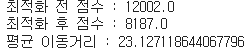

< 2 > 최대치 경우

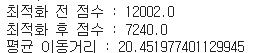

**< 3 > 교차를 PMX 교차로**

PMX :  PMX [Goldberg & Lingle, 1985] 역시 염색체가 순열로 표시되는 경우를 위하여 고안된 교차 연산이다. 두 부모해 S1, S2에 임의로 두 개의 자름선을 정한 다음 두 자름선 사이에 있는 부분을 S1으로부터 복사한다(063). 나머지 위치는 S2로부터 복사하되, 이미 사용한 값이면 같은 값을 가진 S1의 위치를 찾아 그 위치의 S2값을 복사한다(자식해의 0과 6대신 3과 1). 이 값은 아직 사용되지 않았을 수도 있고(예,1), 이미 사용되었을 수도 있다(예, 중간 과정의 X 표시된 3). 이런 식으로 모든 유전자가 중복없이 채워질 때까지 진행한다.

In [ ]:
import numpy as np
import pandas as pd
import requests
import heapq

NUM_OF_CHROMOSOME = 20
SWAP_THRESHOLD = 0.4

MAX_NODE = 79
INF = 2000000
MAX_CNT = [7, 7, 4, 7, 7]

class Chromosome():
    def __init__(self, gene, fitness):
        # gene은 1차원 배열(학교 수업)
        self.Gene = gene
        self.Fitness = fitness

# 교실간의 연결 관계를 나타내는 데이터
!wget -O graph.txt https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
# 학생들의 시간표 정보가 담긴 데이터
!wget -O timetable.csv https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv

import numpy as np

def LoadInitGraph(max_cnt, source):
    graph = np.ones((max_cnt + 1, max_cnt + 1))
    # 모든 배열을 -1로 초기화
    # -1은 갈수 없음을 의미한다.
    graph = graph * -1

    with open(source, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break

            start, to = line.split(' ')
            start = int(start)
            to = int(to)
            # cost를 교실간의 거리로 업데이트하면 정확도가 높아질수 있음.
            # 추후 누군가 해주지 않을까...
            cost = 1

            # 양방향 그래프
            graph[start][to] = cost
            graph[to][start] = cost

    # 자기 자신으로 가는 최소비용은 0이다.
    for i in range(max_cnt + 1):
        graph[i][i] = 0

    return graph

SchoolGraph = LoadInitGraph(MAX_NODE, '/content/graph.txt')

# 이동 가능
print('62와 62 교실을 이동하는데 드는 비용 :', SchoolGraph[62][63])
# 이동 불가능
print('62와 64 교실을 이동하는데 드는 비용 :', SchoolGraph[62][64])


def FloydWarshall(graph, max_cnt):
    # 배열 초기화
    dist = np.where(graph == -1, INF, graph)

    # 3중 반복문 - 플로이드 워셜
    for i in range(max_cnt + 1):
        for t in range(max_cnt + 1):
            for j in range(max_cnt + 1):
                if dist[t][i] + dist[i][j] < dist[t][j]:
                    dist[t][j] = dist[t][i] + dist[i][j]

    return dist

DistGraph = FloydWarshall(SchoolGraph, MAX_NODE)
print('요양원에서 집까지 이동하는데 걸리는 최단경로 :', DistGraph[43][18])


import pandas as pd

def LoadTimetable(source):
    df = pd.read_csv(source, header=None)
    period_list = []
    for index, item in enumerate(MAX_CNT):
        start_index = sum(MAX_CNT[:index])
        temp = df[range(start_index, start_index + item)]
        period_list.append(temp)
    return period_list

Timetable  = LoadTimetable('/content/timetable.csv')
print('월요일 시간표 5개')
Timetable[0].head()


def ExtractSubject(timetable):
    subject = set()
    def extract(inp):
        if '-1' in inp:
            return
        subject.add(inp)

    for i in timetable:
        i.applymap(extract)

    res = dict()
    for index, item in enumerate(subject):
        res[item] = index
    return res

Subject = ExtractSubject(Timetable)

print('전체 수업 개수 :', len(Subject))
print('수업 목록 :', Subject)

# 과목명을 위에서 정의한 과목 숫자로 변경
def ConvertStringToNumber(inp):
    try:
        return Subject[inp]
    except:
        return -1

IndexedTimetable = []
for i in range(len(Timetable)):
    IndexedTimetable.append(Timetable[i].applymap(ConvertStringToNumber))

print("번호가 부여된 월요일 시간표")
IndexedTimetable[0].head()

def GetFitness(gene):
    fitness = 0
    for timetable in IndexedTimetable:
        for subject_list in timetable.iterrows():
            for index in range(len(subject_list[1]) - 1):
                before_sub = subject_list[1][index]
                after_sub = subject_list[1][index + 1]

                if before_sub == -1 or after_sub == -1:
                    continue

                before_cls = gene[before_sub]
                after_cls = gene[after_sub]

                dist = DistGraph[before_cls][after_cls]

                fitness = (fitness + dist)
        return fitness

def GenerateGenesis(max_len, num):
    population = []
    for _ in range(num):
        gene = np.random.choice(range(1, max_len + 1), max_len, replace=False)
        fitness = GetFitness(gene)
        population += [Chromosome(gene, fitness)]
    return population

def Selection(population_set):
    # 점수가 높을 수록 안좋은 유전자이기에 역수를 취해 바꾸어줌.
    fitness_list = [1 / population_set[i].Fitness for i in range(len(population_set))]
    total_fitness = np.sum(fitness_list)
    prob_list = fitness_list / total_fitness

    # 두 집단을 선택하고 두 집단을 Crossover할 예정
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list, replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set), p=prob_list, replace=True)

    progenitor_a = []
    progenitor_b = []
    for i in progenitor_list_a:
        progenitor_a += [population_set[i]]

    for i in progenitor_list_b:
        progenitor_b += [population_set[i]]

    return [progenitor_a, progenitor_b]

# PMX 교차 구현
def PMX_Crossover(parent1, parent2):
    gene_size = len(parent1)
    start, end = sorted(np.random.choice(gene_size, 2, replace=False))

    # Initialize child with genetic material from parent1
    child = [-1] * gene_size
    child[start:end] = parent1[start:end]

    # Find unmatched genetic material from parent2
    for i in range(gene_size):
        if parent2[i] not in child:
            if child[i] == -1:
                child[i] = parent2[i]
            else:
                # If there's a conflict, trace the mapping in parent1 and
                # place the correct value in the child
                conflict_index = parent1.index(parent2[i])
                while start <= conflict_index < end:
                    child[i], i = parent1[conflict_index], parent1.index(parent2[i])

    return child

# 나머지 코드는 이전과 동일합니다.

import random

def SwapMutation(chromosomes):
    gene = chromosomes.Gene

    percentage = random.random()
    if (percentage <= SWAP_THRESHOLD):
        point1, point2 = np.random.choice(range(len(gene)), 2, replace=False)
        gene[point1], gene[point2] = gene[point2], gene[point1]

    fitness = GetFitness(gene)
    return Chromosome(gene, fitness)


NUM_OF_ELITES = 2  # 엘리트 선택할 염색체 수

population = GenerateGenesis(len(Subject), NUM_OF_CHROMOSOME)
global_min = INF
min_chromosome = []

for dur in range(100):
    progenitor_list = Selection(population)
    population = []

    # 엘리트 염색체 선택: 상위 NUM_OF_ELITES 개의 염색체는 그대로 다음 세대로 복사
    elites = sorted(progenitor_list[0], key=lambda chromosome: chromosome.Fitness)[:NUM_OF_ELITES]
    population.extend(elites)

    for _ in range(NUM_OF_CHROMOSOME - NUM_OF_ELITES):
        a, b = np.random.choice(range(len(progenitor_list[0])), 2, replace=False)
        child = OrderCrossover(progenitor_list[0][a], progenitor_list[0][b])
        child = SwapMutation(child)
        population.append(child)

    population = sorted(population, key=lambda chromosome: chromosome.Fitness)
    print('%d회 : %d' % (dur + 1, population[0].Fitness))

    if global_min > population[0].Fitness:
        min_chromosome = population[0]
        global_min = population[0].Fitness
        print('update!')



before_ga = {'창체/223': 25, '수학Ⅰ/420': 62, '화학Ⅰ/214': 18, '문학/323': 44, '창체/421': 63, '창체/324': 46, '인문학/302': 40, '창체/413': 53, '창체/321': 42, '생활과 윤리/324': 46, '영어Ⅰ/222': 24, '영미 문학 읽기/422': 64, '화학Ⅰ/423': 66, '한국지리/421': 63, '문학/223': 25, '창체/322': 43, '일본어Ⅰ/423': 66, '수학Ⅰ/413': 53, '인문학/415': 55, '실용 수학/322': 43, '영어Ⅰ/314': 34, '생명과학Ⅰ/216': 19, '물리학Ⅰ/211': 15, '창체/314': 34, '물리학Ⅰ/414': 54, '화법과 작문/321': 42, '정치와 법/422': 64, '영어Ⅰ/422': 64, '미술/114': 3, '창체/420': 62, '사회문제 탐구/421': 63, '지구과학Ⅰ/216': 19, '수학Ⅰ/0': 43, '문학/321': 42, '창의경영/312': 32, '공학 일반/407': 76, '영어 회화/222': 24, '사회문제 탐구/127': 11, '생활과 과학/225': 28, '중국어Ⅰ/404': 75, '창체/423': 66}
gene = []
for i in Subject:
    gene += [before_ga[i]]
fitness = GetFitness(gene)
print('최적화 전 점수 :', fitness)
print('최적화 후 점수 :', min_chromosome.Fitness)

# 354 = 학생수(추정)
print('평균 이동거리 :', min_chromosome.Fitness / 354)

print('최적 교실 배치')
for sub, cls in zip(Subject, min_chromosome.Gene):
    print(sub, cls, sep=' : ')

# PMX 교차를 사용하여 자식 염색체를 생성하고 엘리트와 새로 생성된 염색체를 선택

--2023-10-27 04:13:43--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/graph.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘graph.txt’

graph.txt           100%[===================>]     595  --.-KB/s    in 0s      

2023-10-27 04:13:43 (46.9 MB/s) - ‘graph.txt’ saved [595/595]

--2023-10-27 04:13:43--  https://raw.githubusercontent.com/rzbsys/Genetic-Algorithm/main/timetable.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177166 (173K) [text/plain]
Saving to: ‘timetable.csv’

Order Crossover와 같이 싸이클 교차보다는 더 효율적인 결과를 많이 도출함.
(Order Croossover 보다도 더 좋은 결과를 훨씬 많이 얻어냄)

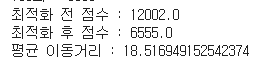

**많이 단축시키는 것을 확인할 수 있었음. (순서 교차, PMX 교차 모두 싸이클 교차보다 비교적 거리 단축이 가능했다고 보여짐**

** < 4 >  변이 과정이나 여러가지 과정 변경이 가능할 것임 **

